In [127]:
# inputs

haps = "/Users/e.smith.5/Documents/PhD/Software/VeTrans/Code/Inference_25_0.csv"

times = "/Users/e.smith.5/Documents/PhD/RSV_project/RSV_haplotype_reconstruction/data/samfire/Times.in"

protein_name = "F Protein"


"F Protein"

In [128]:
# load Julia dependencies

using CSV
using DataFrames
using RCall
using Images
using FileIO

# load R dependencies
R"""
# Function to set CRAN mirror and ensure R can download packages
chooseCRANmirror(ind=1) # Selects a default CRAN mirror

# Install the devtools package if not already installed
if (!requireNamespace("devtools", quietly = TRUE))
  install.packages("devtools")

# Load the devtools package
library(devtools)

# Function to install streamgraph from GitHub
install_streamgraph <- function() {
  tryCatch({
    install_github("hrbrmstr/streamgraph")
    library(streamgraph)
  }, error = function(e) {
    message("Failed to install streamgraph from GitHub.")
    stop(e)
  })
}

# Apply function to install streamgraph from GitHub, and install other packages
install_streamgraph()

# Install ggplot2 and viridis with dependencies
install.packages(c("ggplot2", "viridis", "tidyverse"), dependencies = TRUE)

# Load the packages quietly
suppressPackageStartupMessages({
  library("ggplot2")
  library("viridis")
  library("tidyverse")
  library("streamgraph")
})
"""

┌ Warning: RCall.jl: Using GitHub PAT from the git credential store.
│ Skipping install of 'streamgraph' from a github remote, the SHA1 (76f7173e) has not changed since last install.
│   Use `force = TRUE` to force installation
└ @ RCall /Users/e.smith.5/.julia/packages/RCall/dDAVd/src/io.jl:172



The downloaded binary packages are in
	/var/folders/7v/htx5jcb93rvbnyr12j89csbr0000gp/T//RtmpPwgYI0/downloaded_packages


┌ Warning: RCall.jl: Installing packages into '/Users/e.smith.5/Library/R/arm64/4.4/library'
│ (as 'lib' is unspecified)
│ trying URL 'https://cloud.r-project.org/bin/macosx/big-sur-arm64/contrib/4.4/ggplot2_3.5.1.tgz'
│ Content type 'application/x-gzip' length 4974305 bytes (4.7 MB)
│ ==================================================
│ downloaded 4.7 MB
│ 
│ trying URL 'https://cloud.r-project.org/bin/macosx/big-sur-arm64/contrib/4.4/viridis_0.6.5.tgz'
│ Content type 'application/x-gzip' length 3016921 bytes (2.9 MB)
│ ==================================================
│ downloaded 2.9 MB
│ 
│ trying URL 'https://cloud.r-project.org/bin/macosx/big-sur-arm64/contrib/4.4/tidyverse_2.0.0.tgz'
│ Content type 'application/x-gzip' length 428901 bytes (418 KB)
│ ==================================================
│ downloaded 418 KB
│ 
└ @ RCall /Users/e.smith.5/.julia/packages/RCall/dDAVd/src/io.jl:172


RObject{StrSxp}
 [1] "lubridate"   "forcats"     "stringr"     "dplyr"       "purrr"      
 [6] "readr"       "tidyr"       "tibble"      "tidyverse"   "viridis"    
[11] "viridisLite" "ggplot2"     "streamgraph" "devtools"    "usethis"    
[16] "stats"       "graphics"    "grDevices"   "utils"       "datasets"   
[21] "methods"     "base"       


In [129]:
# load data

haps = CSV.read(haps, DataFrame)

# pass into R
@rput haps 

R"""
library(tidyverse)

times <- colnames(haps)[-1]

haps <- haps %>%
  pivot_longer(
    cols = all_of(times),
    names_to = "Time",
    values_to = "Frequency"
  )
"""

# get back haps dataframe

@rget haps

Row,Haplotype,Time,Frequency
,String,String,Float64
1,GGGCCCCCGAGAAACAATAACAAAGA,1,1.0e-10
2,GGGCCCCCGAGAAACAATAACAAAGA,29,0.00478292
3,GGGCCCCCGAGAAACAATAACAAAGA,50,1.0e-10
4,GGGCCCCCGAGAAACAATAACAAAGA,74,0.0656151
5,GGGCCCCCGAGAAACAATAACAAAGA,83,0.00210821
6,GGGCCCCCGAGAAACAATAACAAAGA,99,0.234145
7,GGGCCCCCGAGAAACAATAACAAAGA,111,0.459868
8,GGGCCCCCGAGAAACAATAACAAAGA,119,0.000582379
9,GGGCCCCCGAGAAACAATAACAAAGA,125,0.632395


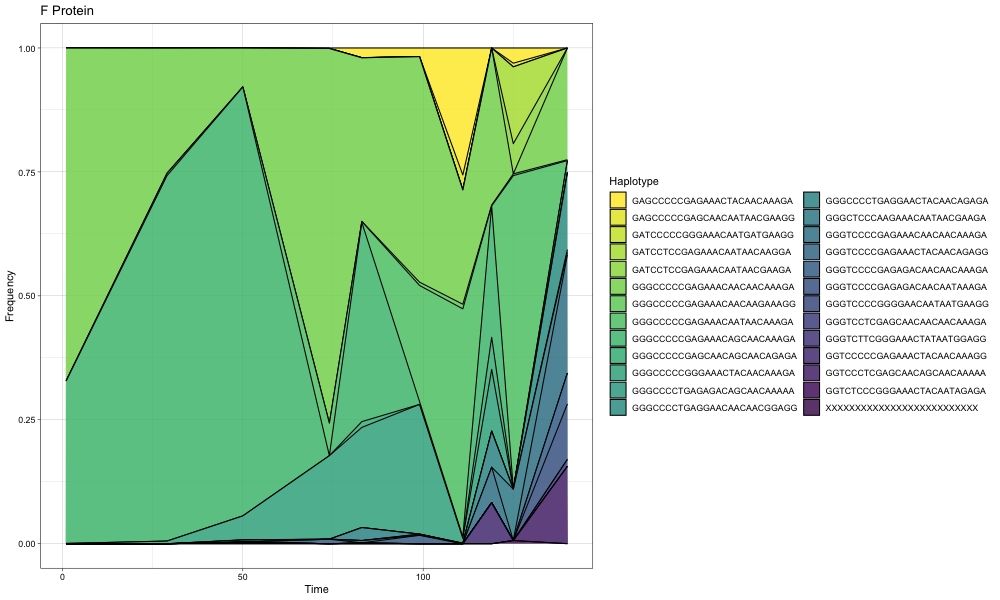

Temporary file deleted successfully.


In [130]:
# plot

@rput haps # pass back to R
@rput protein_name

# Set the path for the temporary image file
output_path = joinpath(pwd(), "ggplot_output.png")

# Create the ggplot in R and save it as a PNG file
R"""
# Extract the first time point frequency for each haplotype
first_time_point <- haps %>% filter(Time == min(Time)) %>% 
                     arrange(desc(Frequency)) %>% 
                     select(Haplotype, InitialFrequency = Frequency)

# Join the initial frequency data back to the main dataset
haps <- haps %>% left_join(first_time_point, by = "Haplotype") %>%
                 arrange(desc(InitialFrequency), Time, Frequency)

p <- ggplot(haps, aes(x = as.numeric(Time), y = as.numeric(Frequency), fill = Haplotype)) + 
    geom_area(alpha = 0.8, linewidth = 0.5, colour = "black") +
    theme_linedraw() +
    labs(title = protein_name, x = "Time", y = "Frequency") +
    theme(legend.position = "right") +
    scale_fill_viridis(discrete = TRUE, direction = -1)

png(filename = $output_path, width = 1000, height = 600)
print(p)
dev.off()
"""

# Read and display the image file in Julia
if isfile(output_path)
    img = load(output_path)
    display(img)

    # Delete the temporary image file after displaying
    rm(output_path; force = true)
    println("Temporary file deleted successfully.")
else
    println("File does not exist.")
end

In [131]:
using DataFrames
using CSV

# Function to find the consensus haplotype at the minimum time point
function consensus_haplotype(df::DataFrame)
    # Find the minimum time point
    min_time = minimum(df[!, :Time])
    
    # Filter the dataframe for the minimum time point
    filtered_df = filter(row -> row.Time == min_time, df)
    
    # Group by haplotype and sum their frequencies
    grouped_df = combine(groupby(filtered_df, :Haplotype), :Frequency => sum)
    
    # Find the haplotype with the maximum summed frequency
    max_freq_row = grouped_df[argmax(grouped_df[!, :Frequency_sum]), :]
    
    return max_freq_row.Haplotype
end

# Call the function and get the consensus haplotype
consensus = consensus_haplotype(haps)
println("The consensus haplotype at the first time point is: $consensus")

The consensus haplotype at the first time point is: GGGCCCCCGAGAAACAACAACAAAGA


In [132]:
# Function to calculate mismatches
function count_mismatches(haplotype::String, consensus::String)::Union{Int, String}
    mismatches = 0
    for i in 1:length(haplotype)
        if haplotype[i] != consensus[i]
            mismatches += 1
        end
    end
    if mismatches == length(haplotype)
        return "X"
    else
        return mismatches
    end
end

# Add new column with mismatch count
haps.Mismatches = [count_mismatches(row.Haplotype, consensus) for row in eachrow(haps)]

println(haps)

# Group the DataFrame by the 'Mismatches' column
@rput haps
R"""
# Grouping by Time and Mismatches, then summing Frequency
haps_mismatched <- haps %>%
    group_by(Time, Mismatches) %>%
    summarize(Frequency = sum(Frequency), .groups = 'drop')
"""

@rget haps_mismatched

260×4 DataFrame
 Row │ Haplotype                   Time    Frequency    Mismatches 
     │ String                      String  Float64      Any        
─────┼─────────────────────────────────────────────────────────────
   1 │ GGGCCCCCGAGAAACAATAACAAAGA  1       1.0e-10      1
   2 │ GGGCCCCCGAGAAACAATAACAAAGA  29      0.00478292   1
   3 │ GGGCCCCCGAGAAACAATAACAAAGA  50      1.0e-10      1
   4 │ GGGCCCCCGAGAAACAATAACAAAGA  74      0.0656151    1
   5 │ GGGCCCCCGAGAAACAATAACAAAGA  83      0.00210821   1
   6 │ GGGCCCCCGAGAAACAATAACAAAGA  99      0.234145     1
   7 │ GGGCCCCCGAGAAACAATAACAAAGA  111     0.459868     1
   8 │ GGGCCCCCGAGAAACAATAACAAAGA  119     0.000582379  1
   9 │ GGGCCCCCGAGAAACAATAACAAAGA  125     0.632395     1
  10 │ GGGCCCCCGAGAAACAATAACAAAGA  140     1.0e-10      1
  11 │ GGGTCCCCGAGAAACTACAACAGAGG  1       1.0e-10      4
  12 │ GGGTCCCCGAGAAACTACAACAGAGG  29      1.00211e-10  4
  13 │ GGGTCCCCGAGAAACTACAACAGAGG  50      1.00225e-10  4
  14 │ GGGTCCCCGAGAAACTACA

Row,Time,Mismatches,Frequency
,String,Any,Float64
1,1,1,0.327427
2,1,4,0.000546811
3,1,2,0.00120543
4,1,5,5.0e-10
5,1,3,4.00003e-10
6,1,7,1.0e-10
7,1,8,1.0e-10
8,1,0,0.670821
9,1,6,1.0e-10


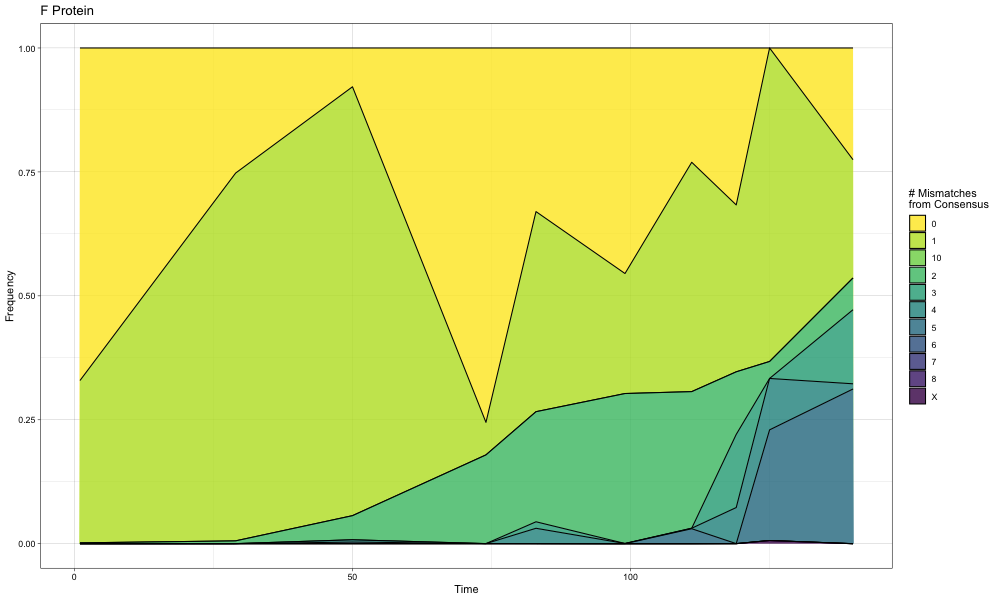

Temporary file deleted successfully.


In [133]:
# area plot for counts of mutations
# plot

@rput haps_mismatched # pass back to R
@rput protein_name

# Set the path for the temporary image file
output_path = joinpath(pwd(), "ggplot_output.png")

# Create the ggplot in R and save it as a PNG file
R"""
# Ensure columns are of correct types
haps_mismatched$Frequency <- as.numeric(unlist(haps_mismatched$Frequency))
haps_mismatched$Mismatches <- as.factor(as.character(unlist(haps_mismatched$Mismatches)))
haps_mismatched$Time <- as.numeric(unlist(haps_mismatched$Time))

p <- haps_mismatched %>% arrange(desc(Time)) %>% 
    ggplot(aes(x = as.numeric(Time), y = Frequency, fill = as.factor(Mismatches))) + 
    geom_area(alpha = 0.8 , size = 0.5, colour = "black") +
    theme_linedraw() +
    labs(title = protein_name, x = "Time", y = "Frequency", fill = "# Mismatches\nfrom Consensus") +
    theme(legend.position = "right") +
    scale_fill_viridis(discrete = TRUE, direction = -1)

png(filename = $output_path, width = 1000, height = 600)
print(p)
dev.off()
"""

# Read and display the image file in Julia
if isfile(output_path)
img = load(output_path)
display(img)

  
# Delete the temporary image file after displaying
rm(output_path; force = true)
println("Temporary file deleted successfully.")
else

println("File does not exist.")

end